# Stock visualization

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math

## Fetching data from yahoo financial

[*********************100%***********************]  3 of 3 completed
nan


<AxesSubplot:xlabel='Date'>

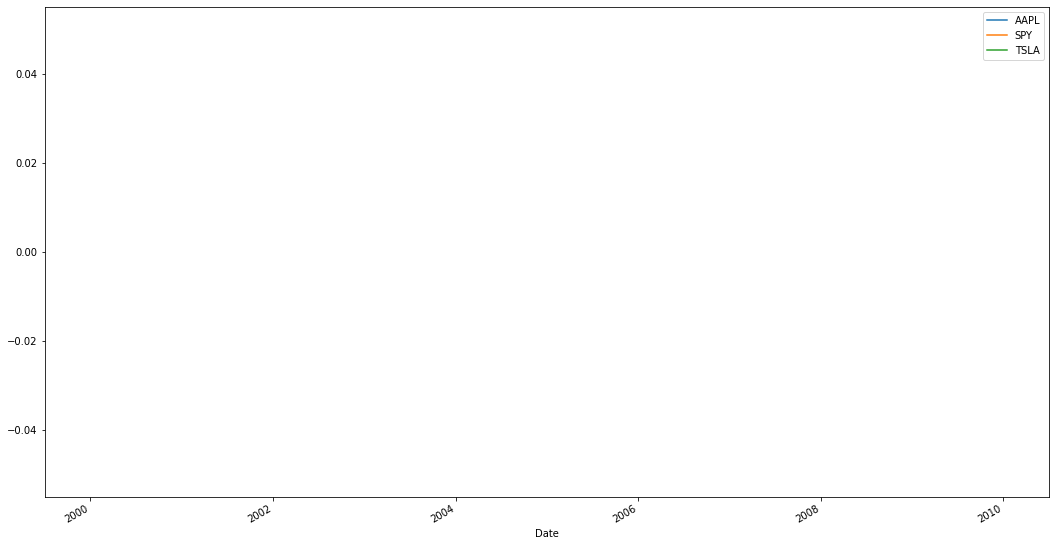

In [2]:
tickers = "SPY AAPL TSLA"

data = yf.download(tickers=tickers, period='1y')
print(min(data['Low']['AAPL']))
data['Low']['AAPL'].head()
adjclose = data['Adj Close']

#normalize the adjusted closes to see the relative performance of each stock 

normprice = adjclose/adjclose.iloc[0]*100

normprice.plot(figsize=(18,10))

In [4]:
data.AAPL.info

AttributeError: 'DataFrame' object has no attribute 'AAPL'

(array([  1.,   0.,   2.,  18.,  79., 103.,  40.,   6.,   1.,   1.]),
 array([-0.21062826, -0.16992422, -0.12922019, -0.08851615, -0.04781211,
        -0.00710808,  0.03359596,  0.0743    ,  0.11500403,  0.15570807,
         0.19641211]),
 [<matplotlib.patches.Polygon at 0x7fe033bb55b0>])

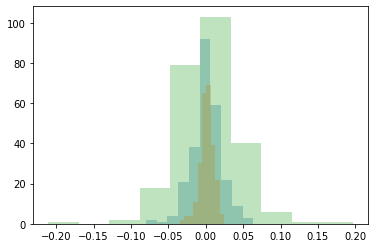

In [3]:
returns = adjclose/adjclose.shift(1) - 1

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=10)
plt.hist(returns['AAPL'], **kwargs)
plt.hist(returns['SPY'], **kwargs)
plt.hist(returns['TSLA'], **kwargs)

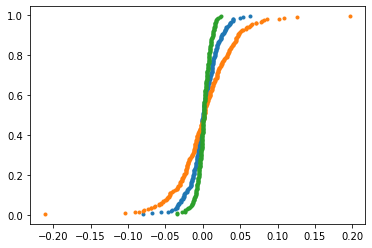

In [4]:
def ecdf(data):
    """Compute ECDF for a one dimensional arrary of measurements"""
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

x, y = ecdf(returns['AAPL'])
plt.plot(x, y, marker='.', linestyle='none')

x, y = ecdf(returns['TSLA'])
plt.plot(x, y, marker='.',linestyle='none')

x, y = ecdf(returns['SPY'])
plt.plot(x, y, marker='.',linestyle='none')

plt.show()

## stock info

In [31]:
tickers = yf.Tickers('msft aapl goog')
# ^ returns a named tuple of Ticker objects

# access each ticker using (example)
tickers.tickers["MSFT"].info['trailingPE']
tickers.tickers["AAPL"].info['trailingPE']
tickers.tickers["GOOG"].info['trailingPE']


In [126]:
for key in tickers.tickers:
    tickers.tickers[key].info

In [129]:
import multiprocessing
# import itertols as it
# ...
# links = get_links('https://www.nytimes.com')
info=None
with multiprocessing.Pool() as p:
    for key in tickers.tickers:
        infos = p.map(tickers.tickers[key].get_info, info)
# all_links = ...

TypeError: 'NoneType' object is not iterable

In [127]:
tickers.tickers['AAPL'].info

{'zip': '95014',
 'sector': 'Technology',
 'fullTimeEmployees': 147000,
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, iPod touch, and other Apple-branded and third-party accessories. It also provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store, that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand r

## stock visualization

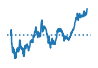

In [7]:
history = apple.history(period='1y')
close = history['Close']

#normalize the adjusted closes to see the relative performance of each stock 

normprice = close/close.iloc[0]

low = close.min()
high = close.max()
current = close.iloc[-1]



fig, ax = plt.subplots(figsize=(1.5,1))

ax.plot(normprice)
ax.axhline(y=1, ls='dotted')

plt.axis('off')
plt.show()

In [175]:
from IPython.display import HTML
import io
import base64

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        text-align: center;
        margin: 5px;
        border: 1px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes, ticker):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            ticker+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))


In [177]:
SP10 = "AAPL MSFT AMZN FB GOOGL GOOG BRK-B TSLA NVDA JPM"
SP23 = "AAPL MSFT AMZN FB GOOGL GOOG BRK-B TSLA NVDA JPM JNJ V UNH PYPL HD PG MA DIS ADBE BAC CMCSA XOM"
SP30 = "AAPL MSFT AMZN FB GOOGL GOOG BRK-B TSLA NVDA JPM JNJ V UNH PYPL HD PG MA DIS ADBE BAC CMCSA XOM PFE CRM CSCO VZ NFLX KO PEP INTC ABT NKE ABBV TMO ACN T MRK LLY CVX WMT AVGO WFC COST"
mostV = "TLRY PFE BA TDOC TEVA NAOV SPOT DUOL QS CAKE BTBT INFI AUPH SPRT U NEGG FB SNDL HMLP BB FLGC CLF GRVI GNRC BNTX WISH EVGO TLRY.TO MCD"

In [336]:
tickers = "AMD TLRY PFE BA TDOC TEVA NAOV SPOT DUOL QS CAKE BTBT INFI AUPH SPRT U NEGG FB SNDL HMLP BB FLGC CLF GRVI GNRC BNTX WISH EVGO TLRY.TO MCD"
type(tickers)

str

In [416]:
import datetime
import dateutil

plt.style.use('dark_background')

def get_startdate(period):
    month_dic = {'1m':1, '3m':3, '6m':6, '1y':12, '2y':24, '3y':36, '5y':60}
    delta = dateutil.relativedelta.relativedelta(months=month_dic[period])
    start = datetime.date.today() - delta
    return start  


class Stocks:
    """ Stocks class for calculating stock stats and 
    visualizing a stock based on the stats.
    
    Attributes:
        tickers (list of str) a list of strings extracted from the tickers
        data (dataframe) representing the historical stock data
        info (nested dictionary) representing each stock's information
        stats (nested dictionary) representing each stock's stats 
            
    """
    import yfinance as yf
    PERIODS = ['1m', '3m', '1y','2y','5y']
    
    def __init__(self, tickers, benchmark, overview=None):
        if type(tickers) == str:
            self.tickers=tickers.split(" ")
        else:
            self.tickers=tickers
        
        self.stats={}
        for ticker in self.tickers:
            self.stats[ticker]={} 
        self.m_stats = {}
  
        self.load_stocks(tickers, benchmark, Stocks.PERIODS[-1]) 
        self.calculate_stats(Stocks.PERIODS)
        if overview is None:
            self.load_info()
        else:
            self.load_info_fromoverview(overview)
        
        
        
    
    def __repr__(self):
        """function to represent the instance of the stocks"""
        return str([stock +": " + str(info['1y']['performance']) for stock, info in self.stats.items()])
            
    def calculate_stats(self, periods):
        """calcuate performance of each stock on given period and store it to dataframe"""
        for period in periods:
            start = get_startdate(period)
            m_close = self.market[start:]['Adj Close']
            m_returns = np.log(m_close/m_close.shift(1))
            self.m_stats[period] = {'performance': m_close.iloc[-1]/m_close.iloc[0], "volatility":m_returns.std()} 

            close = self.data[start:]['Adj Close']
            low = self.data[start:]['Low']
            high = self.data[start:]['High']
            
            for ticker in self.tickers:       
                #to do : exception process when ticker doesn't exist or only one ticker case

                s_close = close[ticker].dropna()
                s_low = low[ticker].dropna()
                s_high = high[ticker].dropna()
                if (len(s_close)>0):
                    change = s_close.iloc[-1]/s_close.iloc[0]
                    returns = np.log(s_close/ s_close.shift(1))
                    half = int(len(returns)/2)
                    vola1 = returns.iloc[:half].std()
                    vola2 = returns.iloc[half:].std()
                    self.stats[ticker][period] = {'performance':change, 
                                          'volatility1':vola1, 'volatility2':vola2, 
                                         "low":s_low.min(),"high":s_high.max(), "current":s_close.iloc[-1]}
         
            
        
    def load_stocks(self, tickers, benchmark, period='5y'):

        self.market = yf.download(tickers=benchmark, period=period)
        self.data = yf.download(tickers=tickers, period=period)   
    
    def load_info(self):
        self.fundamentals = {}
        for ticker in self.tickers:
            try:
                self.fundamentals[ticker] = fv(ticker).TickerFundament()
            except Exception as e:
                self.fundamentals[ticker] = {"P/E":"-"}
                print(e)
    
    def load_info_fromoverview(self, overview):
        self.fundamentals = df.set_index('Ticker').T.to_dict()

            
    def visualize(self, period='1y'):
        oPlot = FlowLayout() # create an empty FlowLayout
        m_perf = self.m_stats[period]["performance"]
        m_vola = self.m_stats[period]["volatility"]
        for ticker, stats in self.stats.items():       
            
            
            #height =  math.ceil(stats["performance"]/self.m_stats[period]["performance"])
            fig, ax = plt.subplots(figsize=(1,2))    
            ax.patch.set_facecolor('black')
            self.pillarplot(ax, stats[period]["performance"]/m_perf, 
                            stats[period]["volatility1"]/m_vola,
                            stats[period]["volatility2"]/m_vola, 
                            stats[period]["low"], stats[period]["high"], stats[period]["current"],
                            self.get_color(self.fundamentals[ticker]["P/E"])
                           ) 

            fig.savefig("stocklookbookapp/static/stocks/"+ticker+"_"+period+".svg", bbox_inches='tight', pad_inches=0.0, format="svg")
            oPlot.add_plot(ax, ticker) # pass it to the FlowLayout to save as an image
            plt.close() # this gets rid of the plot so it doesn't appear in the cell


        oPlot.PassHtmlToCell()
        
    
    def pillarplot(self, ax, performance, vola1, vola2, low, high, current, color, width=1, height=1):
    
        
        dw, dx1, dy1, dx2, dy2 = self.get_cpoints(vola1, vola2)

        bottom_left = np.array([0,0]) 
        bottom_right = np.array([width,0])
        top_left = bottom_left + [0, height*performance]
        top_right = bottom_right + [0, height*performance]


        c1_left = (bottom_left*3/4 + top_left/4) + [width*dx1,0] -[0, dy1]
        c1_right = (bottom_right*3/4 + top_right/4) - [width*dx1,0] -[0, dy1]

        waist_left = (bottom_left + top_left)/2 + [width*dw,0] 
        waist_right = (bottom_right + top_right)/2 - [width*dw,0]


        c2_left = (bottom_left/4 + top_left*3/4) + [width*dx2, 0] + [0,dy2]
        c2_right = (bottom_right/4 + top_right*3/4) - [width*dx2, 0] + [0,dy2]



        Path = mpath.Path

        codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.CURVE3,Path.CURVE3, Path.LINETO, Path.CURVE3,Path.CURVE3,Path.CURVE3,Path.CURVE3, Path.CLOSEPOLY]
        vertices = [bottom_left, c1_left, waist_left, c2_left, top_left, top_right, c2_right, waist_right, c1_right, bottom_right, bottom_left]
        
        
        
        pp = mpatches.PathPatch(Path(vertices, codes), color=color, alpha=1)

        ax.add_patch(pp)
        pos = (current-low)/(high-low)*width
        ax.scatter(pos,0, color='w',s=10, zorder=2)

        ax.axis('off')
        ax.set_xlim([-0.25, 1.25])
        ax.set_ylim([-0.1, 3.5])
        ax.set_aspect('equal', 'box')
        #fig.tight_layout()
        
        return
    
    @staticmethod
    def get_cpoints(vola1, vola2):
        """calcaulate the points of quadratic bezier curve based on the volatility of stock"""

        rv1 = (vola1-1)/10
        rv2 = (vola2-1)/10
        LIMIT = 4.8/10


        dx1 = min(rv1, LIMIT)
        dx2 = min(rv2, LIMIT)

        dy = lambda x: 0 if (x < LIMIT) else min(1/(4/LIMIT)*(x-LIMIT), 1/4)
        dy1 = dy(rv1)
        dy2 = dy(rv2)

        w = (dx1+dx2)/2

        return w, dx1, dy1, dx2, dy2
    
    
    @staticmethod
    def get_color(PE):
        """get a color to represent P/E ratio"""
        cm = plt.get_cmap('viridis')
        
        try:
            num = float(PE)/100
            if np.isnan(num):
                color = (0.7, 0.7, 0.7)
            else:
                color = cm(num)
        except:    
            color = (0.7, 0.7, 0.7)
                      
        return color
        
    #def add_stocks(tickers):
        

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  29 of 29 completed
404 Client Error: Not Found for url: https://finviz.com/quote.ashx?t=TLRY.TO
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops
oops



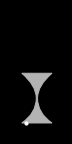
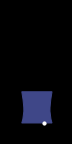
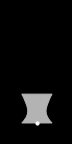
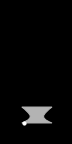
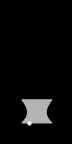
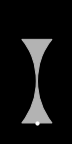
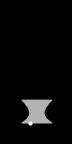
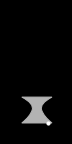
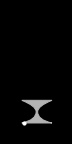
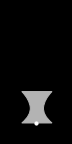
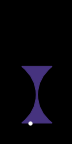
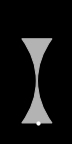
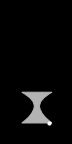
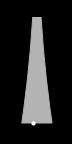
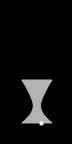
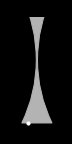
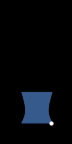
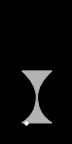
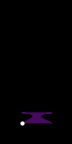
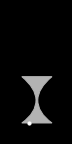
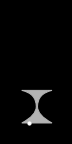
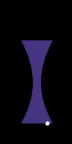
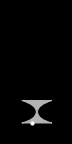
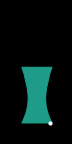
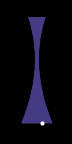
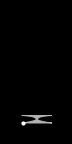
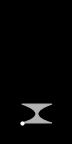
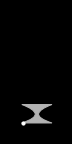
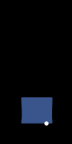

In [412]:
mv = Stocks(mostV,'SPY')
mv.visualize()

In [361]:
mv.fundamentals['MCD']

{'Company': "McDonald's Corporation",
 'Sector': 'Consumer Cyclical',
 'Industry': 'Restaurants',
 'Country': 'USA',
 'Index': 'DJIA S&P500',
 'P/E': '25.72',
 'EPS (ttm)': '9.18',
 'Insider Own': '0.05%',
 'Shs Outstand': '746.60M',
 'Perf Week': '-0.17%',
 'Market Cap': '177.16B',
 'Forward P/E': '23.88',
 'EPS next Y': '8.90%',
 'Insider Trans': '-11.39%',
 'Shs Float': '746.45M',
 'Perf Month': '-0.03%',
 'Income': '6.90B',
 'PEG': '1.23',
 'EPS next Q': '2.45',
 'Inst Own': '68.90%',
 'Short Float': '0.83%',
 'Perf Quarter': '1.53%',
 'Sales': '21.74B',
 'P/S': '8.15',
 'EPS this Y': '-21.00%',
 'Inst Trans': '-0.12%',
 'Short Ratio': '2.72',
 'Perf Half Y': '13.25%',
 'Book/sh': '-7.78',
 'P/B': '-',
 'ROA': '13.40%',
 'Target Price': '265.79',
 'Perf Year': '11.55%',
 'Cash/sh': '-',
 'P/C': '-',
 'EPS next 5Y': '20.87%',
 'ROE': '-94.00%',
 '52W Range From': '202.73',
 '52W Range To': '247.05',
 'Perf YTD': '10.07%',
 'Dividend': '5.16',
 'P/FCF': '54.23',
 'EPS past 5Y': '5.60

In [213]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

cmaps = OrderedDict()

cmaps['Sequential (2)'] = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']
cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']
cmaps['Miscellaneous'] = [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar']

ModuleNotFoundError: No module named 'colorspacious'

# portfolio Optimization

The following single line of code generates a random array of weights that sum to 1.0. In the portfolio, one of the assumptions is that all funds will deployed to the assets in the portfolio according to some weighting.

In [ ]:
weights = np.random.dirichlet(np.ones(6), size=1)
weights = weights[0]
print(weights)

From these weights, we can calculate the expected weighted return of the portfolio of assets using these random weights.

In [ ]:
exp_port_return = np.sum(returns.mean()*weights)*252
print('portfolio mean: ',exp_port_return)

In [ ]:
np.dot(returns.cov()*252, weights)

In [ ]:
port_var = np.dot(weights.T, np.dot(returns.cov()*252, weights))
port_vol = np.sqrt(port_var)
print(port_var)
print('portfolio volatility: ', port_vol)

In [ ]:
import time

def portfolio_simulation(assets, startdate, iterations):
    '''
    Runs a simulation by randomly selecting portfolio weights a specified
    number of times (iterations), returns the list of results and plots 
    all the portfolios as well.
    
    Parameters:
    -----------  
        assets: list
            all the assets that are to be pulled from Quandl to comprise
            our portfolio.    
        iterations: int 
            the number of randomly generated portfolios to build.
    
    Returns:
    --------
        port_returns: array
            array of all the simulated portfolio returns.
        port_vols: array
            array of all the simulated portfolio volatilities.
    '''
    
    start = time.time()
    num_assets = len(assets.split())
    
    data = yf.download(tickers=assets, start=startdate)
    acp = data['Adj Close']
    returns = np.log(acp/acp.shift(1))
    
    port_returns = []
    port_volats = []
    
    for i in range(iterations):
        weights = np.random.dirichlet(np.ones(num_assets), size=1)
        weights = weights[0]
        port_returns.append(np.sum(returns.mean()*weights) * 252)
        port_volats.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights))))
        
    port_returns = np.array(port_returns)
    port_volats = np.array(port_volats)
    
    plt.figure(figsize=(18,10))
    plt.scatter(port_volats, port_returns, c=port_returns/port_volats, marker='o')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label = 'Sharpe ratio')
    
    print('Elapsed Time: {} seconds'.format(time.time() - start))

        print('Elapsed Time: {} seconds'.format(time.time() - start))

    return port_returns, port_volats
    

    

In [ ]:
assets = "SPY AAPL MSFT QQQ VWO GLD"
startdate = "2015-01-01"

In [ ]:
portfolio_simulation(assets, startdate, 5000)

In [ ]:
def portfolio_stats(weights):
    '''
    We can gather the portfolio performance metrics for a specific set of weights.
    This function will be important because we'll want to pass it to an optmization
    function to get the portfolio with the best desired characteristics.
    
    Note: Sharpe ratio here uses a risk-free short rate of 0.
    
    Paramaters: 
    -----------
        weights: array, 
            asset weights in the portfolio.
        returns: dataframe
            a dataframe of returns for each asset in the trial portfolio    
    
    Returns: 
    --------
        dict of portfolio statistics - mean return, volatility, sharp ratio.
    '''
    
    # Convert to array in case list was passed instead.
    weights = np.array(weights)
    port_return = np.sum(returns.mean()*weights)*252
    port_volat = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    sharpe = port_return/port_volat
    
    return {'return': port_return, 'volatility':port_volat, 'sharpe':sharpe}

## Minimization Functions


In [ ]:
def minimize_sharpe(weights):  
    return -portfolio_stats(weights)['sharpe'] 

def minimize_volatility(weights):  
    # Note that we don't return the negative of volatility here because we 
    # want the absolute value of volatility to shrink, unlike sharpe.
    return portfolio_stats(weights)['volatility'] 

def minimize_return(weights): 
    return -portfolio_stats(weights)['return']

## The Optimization Function

The scipy.optimize function accepts several parameters in order to optimize on your desired variable. Some of these are especially important in the portfolio optimization process.

- constraints: In this case, our key constraint is that all the portfolio weights should sum to 1.0. What this means, practically, is that all of our cash should be invested in an asset or ETF.
- bounds: Bounds is going to refer to how much of our portfolio one asset can take up, from 0.0 to 1.0. 0.0 being a 0% position, and 1.0 being a 100% position (That stock or ETF is our only holding). Note that we can change this if we want so that we don’t take on too much concentration risk. Concentration risk is the loss of diversification benefits you can encouter if one stock or ETF takes up too much of your portfolio. In reality, you might want to set these bounds to (0, 0.2), which means a single stock can only take up a maximum of 20% of the portfolio.
- initializer: Initializer just sets the initial weights of the optimization algorithm so that it has a starting point. Here we’ll just set them so that each stock takes up an equal percentage of the portfolio.

In [ ]:
num_assets = 6
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(num_assets))
initializer = num_assets * [1./num_assets,]

print (initializer)
print (bounds)

In [ ]:
import scipy.optimize as optimize
optimal_sharpe=optimize.minimize(minimize_sharpe,
                                 initializer,
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)
print(optimal_sharpe)

In [ ]:
optimal_sharpe_weights=optimal_sharpe['x'].round(4)
list(zip(assets,list(optimal_sharpe_weights)))

In [ ]:
optimal_stats = portfolio_stats(optimal_sharpe_weights)
print(optimal_stats)

print('Optimal Portfolio Return: ', round(optimal_stats['return']*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats['volatility']*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats['sharpe'],4))

In [ ]:
df = px.data.stocks(indexed=True) - 1
fig = px.area(df, facet_col="company", facet_col_wrap=3)
fig.show()

In [ ]:
# Using plotly.express
import plotly.express as px

fig = px.line(adjclose)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = px.line(df, x='Date', y='AAPL.High', title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

# references

https://kevinvecmanis.io/finance/optimization/2019/04/02/Algorithmic-Portfolio-Optimization.html

In [85]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# Yahoo! Finance market data downloader (+fix for Pandas Datareader)
# https://github.com/ranaroussi/yfinance
#
# Copyright 2017-2019 Ran Aroussi
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

from __future__ import print_function

import requests as _requests
import re as _re
import pandas as _pd
import numpy as _np
import sys as _sys
import re as _re

try:
    import ujson as _json
except ImportError:
    import json as _json


user_agent_headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

def empty_df(index=[]):
    empty = _pd.DataFrame(index=index, data={
        'Open': _np.nan, 'High': _np.nan, 'Low': _np.nan,
        'Close': _np.nan, 'Adj Close': _np.nan, 'Volume': _np.nan})
    empty.index.name = 'Date'
    return empty


def get_html(url, proxy=None, session=None):
    session = session or _requests
    html = session.get(url=url, proxies=proxy, headers=user_agent_headers).text
    return html


def get_json(url, proxy=None, session=None):

    session = session or _requests
    start = time.time()
    html = session.get(url=url, proxies=proxy, headers=user_agent_headers).text
    if "QuoteSummaryStore" not in html:
        html = session.get(url=url, proxies=proxy).text
     
        if "QuoteSummaryStore" not in html:
            return {}

    json_str = html.split('root.App.main =')[1].split(
        '(this)')[0].split(';\n}')[0].strip()
    
    data = _json.loads(json_str)[
        'context']['dispatcher']['stores']['QuoteSummaryStore']
    # return data
    new_data = _json.dumps(data).replace('{}', 'null')
    new_data = _re.sub(
        r'\{[\'|\"]raw[\'|\"]:(.*?),(.*?)\}', r'\1', new_data)
    
    return _json.loads(new_data)


def camel2title(o):
    return [_re.sub("([a-z])([A-Z])", r"\g<1> \g<2>", i).title() for i in o]


def auto_adjust(data):
    df = data.copy()
    ratio = df["Close"] / df["Adj Close"]
    df["Adj Open"] = df["Open"] / ratio
    df["Adj High"] = df["High"] / ratio
    df["Adj Low"] = df["Low"] / ratio

    df.drop(
        ["Open", "High", "Low", "Close"],
        axis=1, inplace=True)

    df.rename(columns={
        "Adj Open": "Open", "Adj High": "High",
        "Adj Low": "Low", "Adj Close": "Close"
    }, inplace=True)

    df = df[["Open", "High", "Low", "Close", "Volume"]]
    return df[["Open", "High", "Low", "Close", "Volume"]]


def back_adjust(data):
    """ back-adjusted data to mimic true historical prices """

    df = data.copy()
    ratio = df["Adj Close"] / df["Close"]
    df["Adj Open"] = df["Open"] * ratio
    df["Adj High"] = df["High"] * ratio
    df["Adj Low"] = df["Low"] * ratio

    df.drop(
        ["Open", "High", "Low", "Adj Close"],
        axis=1, inplace=True)

    df.rename(columns={
        "Adj Open": "Open", "Adj High": "High",
        "Adj Low": "Low"
    }, inplace=True)

    return df[["Open", "High", "Low", "Close", "Volume"]]


def parse_quotes(data, tz=None):
    timestamps = data["timestamp"]
    ohlc = data["indicators"]["quote"][0]
    volumes = ohlc["volume"]
    opens = ohlc["open"]
    closes = ohlc["close"]
    lows = ohlc["low"]
    highs = ohlc["high"]

    adjclose = closes
    if "adjclose" in data["indicators"]:
        adjclose = data["indicators"]["adjclose"][0]["adjclose"]

    quotes = _pd.DataFrame({"Open": opens,
                            "High": highs,
                            "Low": lows,
                            "Close": closes,
                            "Adj Close": adjclose,
                            "Volume": volumes})

    quotes.index = _pd.to_datetime(timestamps, unit="s")
    quotes.sort_index(inplace=True)

    if tz is not None:
        quotes.index = quotes.index.tz_localize(tz)

    return quotes


def parse_actions(data, tz=None):
    dividends = _pd.DataFrame(columns=["Dividends"])
    splits = _pd.DataFrame(columns=["Stock Splits"])

    if "events" in data:
        if "dividends" in data["events"]:
            dividends = _pd.DataFrame(
                data=list(data["events"]["dividends"].values()))
            dividends.set_index("date", inplace=True)
            dividends.index = _pd.to_datetime(dividends.index, unit="s")
            dividends.sort_index(inplace=True)
            if tz is not None:
                dividends.index = dividends.index.tz_localize(tz)

            dividends.columns = ["Dividends"]

        if "splits" in data["events"]:
            splits = _pd.DataFrame(
                data=list(data["events"]["splits"].values()))
            splits.set_index("date", inplace=True)
            splits.index = _pd.to_datetime(splits.index, unit="s")
            splits.sort_index(inplace=True)
            if tz is not None:
                splits.index = splits.index.tz_localize(tz)
            splits["Stock Splits"] = splits["numerator"] / \
                splits["denominator"]
            splits = splits["Stock Splits"]

    return dividends, splits


class ProgressBar:
    def __init__(self, iterations, text='completed'):
        self.text = text
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 50
        self.__update_amount(0)
        self.elapsed = 1

    def completed(self):
        if self.elapsed > self.iterations:
            self.elapsed = self.iterations
        self.update_iteration(1)
        print('\r' + str(self), end='')
        _sys.stdout.flush()
        print()

    def animate(self, iteration=None):
        if iteration is None:
            self.elapsed += 1
            iteration = self.elapsed
        else:
            self.elapsed += iteration

        print('\r' + str(self), end='')
        _sys.stdout.flush()
        self.update_iteration()

    def update_iteration(self, val=None):
        val = val if val is not None else self.elapsed / float(self.iterations)
        self.__update_amount(val * 100.0)
        self.prog_bar += '  %s of %s %s' % (
            self.elapsed, self.iterations, self.text)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * \
            num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [116]:
ap = TickerBase('AAPL')
ap.get_info()

{'zip': '95014',
 'sector': 'Technology',
 'fullTimeEmployees': 147000,
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, iPod touch, and other Apple-branded and third-party accessories. It also provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store, that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand r

In [110]:
get_json('https://finance.yahoo.com/quote/AAPL')

{'defaultKeyStatistics': {'annualHoldingsTurnover': None,
  'enterpriseToRevenue': 7.442,
  'beta3Year': None,
  'profitMargins': 0.25004,
  'enterpriseToEbitda': 23.289,
  '52WeekChange': 0.15547943,
  'morningStarRiskRating': None,
  'forwardEps': 5.67,
  'revenueQuarterlyGrowth': None,
  'sharesOutstanding': 16530199552,
  'fundInceptionDate': None,
  'annualReportExpenseRatio': None,
  'totalAssets': None,
  'bookValue': 3.882,
  'sharesShort': 93105968,
  'sharesPercentSharesOut': 0.0056,
  'fundFamily': None,
  'lastFiscalYearEnd': 1601078400,
  'heldPercentInstitutions': 0.58432,
  'netIncomeToCommon': 86801997824,
  'trailingEps': 5.108,
  'lastDividendValue': None,
  'SandP52WeekChange': 0.26302207,
  'priceToBook': 39.413963,
  'heldPercentInsiders': 0.00071000005,
  'nextFiscalYearEnd': 1664150400,
  'yield': None,
  'mostRecentQuarter': 1624665600,
  'shortRatio': 1.19,
  'sharesShortPreviousMonthDate': 1626307200,
  'floatShares': 16513305231,
  'beta': 1.202797,
  'enterp

In [133]:
base = 'https://finance.yahoo.com/quote/'
info = {}
with multiprocessing.Pool() as p:
    for key in ['AAPL','MSFT', 'GOOGL']:
        infos = p.map(get_json(base+key), info)

In [135]:
infos

[]

In [113]:
import http.client

conn = http.client.HTTPSConnection("apidojo-yahoo-finance-v1.p.rapidapi.com")

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "e71460c88cmsh80ec8df46a33373p1464d5jsn538bf9eaf0f6"
    }

conn.request("GET", "/stock/v2/get-summary?symbol=AMRN&region=US", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"defaultKeyStatistics":{"annualHoldingsTurnover":{},"enterpriseToRevenue":{"raw":2.66,"fmt":"2.66"},"beta3Year":{},"profitMargins":{"raw":0.00696,"fmt":"0.70%"},"enterpriseToEbitda":{"raw":165.403,"fmt":"165.40"},"52WeekChange":{"raw":0.079365134,"fmt":"7.94%"},"morningStarRiskRating":{},"forwardEps":{"raw":-0.12,"fmt":"-0.12"},"revenueQuarterlyGrowth":{},"sharesOutstanding":{"raw":394772000,"fmt":"394.77M","longFmt":"394,772,000"},"fundInceptionDate":{},"annualReportExpenseRatio":{},"totalAssets":{},"bookValue":{"raw":1.633,"fmt":"1.63"},"sharesShort":{"raw":12941727,"fmt":"12.94M","longFmt":"12,941,727"},"sharesPercentSharesOut":{"raw":0.0327,"fmt":"3.27%"},"fundFamily":null,"lastFiscalYearEnd":{"raw":1609372800,"fmt":"2020-12-31"},"heldPercentInstitutions":{"raw":0.33825,"fmt":"33.83%"},"netIncomeToCommon":{"raw":4320000,"fmt":"4.32M","longFmt":"4,320,000"},"trailingEps":{"raw":0.01,"fmt":"0.01"},"lastDividendValue":{},"SandP52WeekChange":{"raw":0.26302207,"fmt":"26.30%"},"priceToB

In [112]:
import http.client

conn = http.client.HTTPSConnection("apidojo-yahoo-finance-v1.p.rapidapi.com")

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "e71460c88cmsh80ec8df46a33373p1464d5jsn538bf9eaf0f6"
    }

conn.request("GET", "/market/get-trending-tickers?region=US", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"finance":{"result":[{"count":20,"quotes":[{"language":"en-US","region":"US","quoteType":"EQUITY","triggerable":true,"quoteSourceName":"Nasdaq Real Time Price","marketState":"REGULAR","regularMarketPrice":111.82,"regularMarketTime":1630522688,"regularMarketChange":-8.959999,"shortName":"AbbVie Inc.","exchange":"NYQ","market":"us_market","priceHint":2,"sourceInterval":15,"exchangeTimezoneName":"America/New_York","exchangeTimezoneShortName":"EDT","gmtOffSetMilliseconds":-14400000,"esgPopulated":false,"tradeable":false,"exchangeDataDelayedBy":0,"regularMarketChangePercent":-7.418446,"regularMarketPreviousClose":120.78,"fullExchangeName":"NYSE","longName":"AbbVie Inc.","symbol":"ABBV"},{"language":"en-US","region":"US","quoteType":"EQUITY","triggerable":true,"quoteSourceName":"Nasdaq Real Time Price","marketState":"REGULAR","regularMarketPrice":17.925,"regularMarketTime":1630522687,"regularMarketChange":-2.0349998,"shortName":"Lucid Group, Inc.","exchange":"NMS","market":"us_market","pric

In [342]:
import pandas as pd
from finvizfinance.quote import finvizfinance as fv

stock = fv('tsla')
info = stock.TickerFundament()

In [343]:
info

{'Company': 'Tesla, Inc.',
 'Sector': 'Consumer Cyclical',
 'Industry': 'Auto Manufacturers',
 'Country': 'USA',
 'Index': 'S&P 500',
 'P/E': '393.79',
 'EPS (ttm)': '1.91',
 'Insider Own': '0.10%',
 'Shs Outstand': '963.33M',
 'Perf Week': '3.01%',
 'Market Cap': '725.31B',
 'Forward P/E': '108.08',
 'EPS next Y': '31.51%',
 'Insider Trans': '-17.95%',
 'Shs Float': '802.29M',
 'Perf Month': '7.70%',
 'Income': '2.15B',
 'PEG': '7.61',
 'EPS next Q': '1.38',
 'Inst Own': '41.30%',
 'Short Float': '3.34%',
 'Perf Quarter': '24.74%',
 'Sales': '41.86B',
 'P/S': '17.33',
 'EPS this Y': '165.00%',
 'Inst Trans': '-0.80%',
 'Short Ratio': '1.32',
 'Perf Half Y': '11.78%',
 'Book/sh': '25.54',
 'P/B': '29.48',
 'ROA': '4.20%',
 'Target Price': '701.85',
 'Perf Year': '79.99%',
 'Cash/sh': '16.85',
 'P/C': '44.69',
 'EPS next 5Y': '51.76%',
 'ROE': '10.00%',
 '52W Range From': '329.88',
 '52W Range To': '900.40',
 'Perf YTD': '6.70%',
 'Dividend': '-',
 'P/FCF': '79.42',
 'EPS past 5Y': '19.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  37 of 37 completed



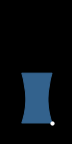
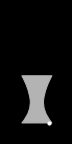
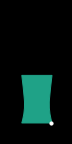
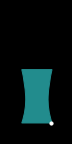
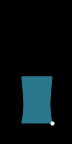
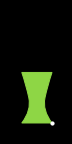
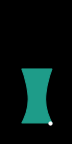
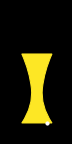
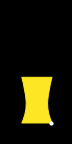
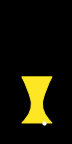
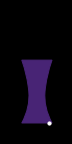
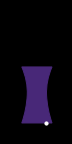
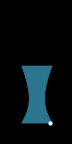
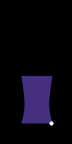
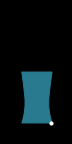
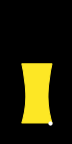
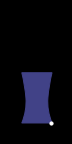
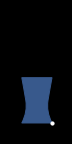
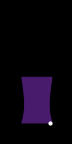
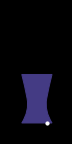
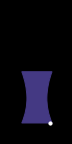
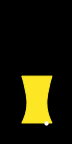
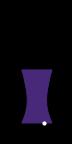
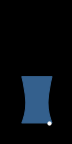
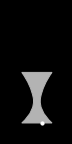
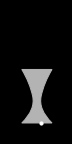
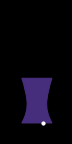
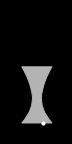
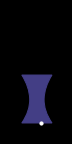
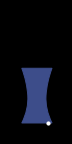
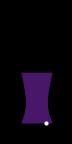
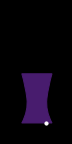
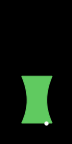
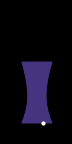
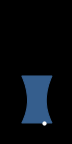
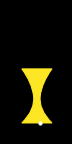
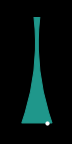

In [417]:
from finvizfinance.screener.overview import Overview
from finvizfinance.screener.custom import Custom

#foverview = Overview()
fcustom = Custom()
filters_dict = {'Index':'S&P 500','Country':'USA', 'Performance':'Year +100%' }
#foverview.set_filter(filters_dict=filters_dict)
#df = foverview.ScreenerView()
fcustom.set_filter(filters_dict=filters_dict)
df = fcustom.ScreenerView(order = 'Performance (Month)', ascend=False, columns=[0, 1, 2, 3, 6, 7, 42, 43, 65, 66, 67])
df.head()

tickers = df.Ticker.tolist()
perf_stocks = Stocks(tickers, benchmark='SPY', overview=df)
perf_stocks.visualize()

In [415]:
float(perf_stocks.fundamentals['FANG']['P/E'])

nan

In [399]:
df.set_index('Ticker').T.to_dict()

{'PWR': {'Company': 'Quanta Services, Inc.',
  'Sector': 'Industrials',
  'Market Cap': 15830000000.0,
  'P/E': 31.07,
  'Perf Week': 0.1333,
  'Perf Month': 0.2566,
  'Price': 115.71,
  'Change': 0.0039000000000000003,
  'Volume': 1088834.0},
 'OGN': {'Company': 'Organon & Co.',
  'Sector': 'Healthcare',
  'Market Cap': 8870000000.0,
  'P/E': nan,
  'Perf Week': 0.0319,
  'Perf Month': 0.20170000000000002,
  'Price': 34.97,
  'Change': -0.018799999999999997,
  'Volume': 2178913.0},
 'ETSY': {'Company': 'Etsy, Inc.',
  'Sector': 'Consumer Cyclical',
  'Market Cap': 26340000000.0,
  'P/E': 61.63,
  'Perf Week': -0.0069,
  'Perf Month': 0.17300000000000001,
  'Price': 214.77,
  'Change': -0.0077,
  'Volume': 1632491.0},
 'CTLT': {'Company': 'Catalent, Inc.',
  'Sector': 'Healthcare',
  'Market Cap': 24180000000.0,
  'P/E': 45.79,
  'Perf Week': 0.0913,
  'Perf Month': 0.16949999999999998,
  'Price': 142.35,
  'Change': 0.0088,
  'Volume': 1165923.0},
 'CZR': {'Company': 'Caesars Entertai

In [380]:
columns = {
    0: 'No.',
    1: 'Ticker',
    2: 'Company',
    3: 'Sector',
    4: 'Industry',
    5: 'Country',
    6: 'Market Cap.',
    7: 'P/E',
    8: 'Forward P/E',
    9: 'PEG',
    10: 'P/S',
    11: 'P/B',
    12: 'P/Cash',
    13: 'P/Free Cash Flow',
    14: 'Dividend Yield',
    15: 'Payout Ratio',
    16: 'EPS',
    17: 'EPS growth this year',
    18: 'EPS growth next year',
    19: 'EPS growth past 5 years',
    20: 'EPS growth next 5 years',
    21: 'Sales growth past 5 years',
    22: 'EPS growth qtr over qtr',
    23: 'Sales growth qtr over qtr',
    24: 'Shares Outstanding',
    25: 'Shares Float',
    26: 'Insider Ownership',
    27: 'Insider Transactions',
    28: 'Institutional Ownership',
    29: 'Institutional Transactions',
    30: 'Float Short',
    31: 'Short Ratio',
    32: 'Return on Assets',
    33: 'Return on Equity',
    34: 'Return on Investments',
    35: 'Current Ratio',
    36: 'Quick Ratio',
    37: 'Long Term Debt/Equity',
    38: 'Total Debt/Equity',
    39: 'Gross Margin',
    40: 'Operating Margin',
    41: 'Net Profit Margin',
    42: 'Performance (Week)',
    43: 'Performance (Month)',
    44: 'Performance (Quarter)',
    45: 'Performance (Half Year)',
    46: 'Performance (Year)',
    47: 'Performance (YearToDate)',
    48: 'Beta',
    49: 'Average True Range',
    50: 'Volatility (Week)',
    51: 'Volatility (Month)',
    52: '20-Day Simple Moving Average',
    53: '50-Day Simple Moving Average',
    54: '200-Day Simple Moving Average',
    55: '50-Day High',
    56: '50-Day Low',
    57: '52-Week High',
    58: '52-Week Low',
    59: 'RSI',
    60: 'Change from Open',
    61: 'Gap',
    62: 'Analyst Recom.',
    63: 'Average Volume',
    64: 'Relative Volume',
    65: 'Price',
    66: 'Change',
    67: 'Volume',
    68: 'Earnings Date',
    69: 'Target Price',
    70: 'IPO Date'
}

['Exchange',
 'Index',
 'Sector',
 'Industry',
 'Country',
 'Market Cap.',
 'P/E',
 'Forward P/E',
 'PEG',
 'P/S',
 'P/B',
 'Price/Cash',
 'Price/Free Cash Flow',
 'EPS growththis year',
 'EPS growthnext year',
 'EPS growthpast 5 years',
 'EPS growthnext 5 years',
 'Sales growthpast 5 years',
 'EPS growthqtr over qtr',
 'Sales growthqtr over qtr',
 'Dividend Yield',
 'Return on Assets',
 'Return on Equity',
 'Return on Investment',
 'Current Ratio',
 'Quick Ratio',
 'LT Debt/Equity',
 'Debt/Equity',
 'Gross Margin',
 'Operating Margin',
 'Net Profit Margin',
 'Payout Ratio',
 'InsiderOwnership',
 'InsiderTransactions',
 'InstitutionalOwnership',
 'InstitutionalTransactions',
 'Float Short',
 'Analyst Recom.',
 'Option/Short',
 'Earnings Date',
 'Performance',
 'Performance 2',
 'Volatility',
 'RSI (14)',
 'Gap',
 '20-Day Simple Moving Average',
 '50-Day Simple Moving Average',
 '200-Day Simple Moving Average',
 'Change',
 'Change from Open',
 '20-Day High/Low',
 '50-Day High/Low',
 '52

0.3709
0.20199999999999999
0.1576
0.2767
0.0782
0.1176
0.7044
0.2755
0.47119999999999995
0.2248
0.1297
0.27699999999999997
0.41359999999999997
0.2132
0.179
0.1463
0.10619999999999999
0.1017
0.1399
0.2516
0.1834
0.4604
0.537
0.1032
0.1016
0.1714
0.36
0.2528
0.12279999999999999
0.11289999999999999
0.541
0.5236
0.30219999999999997
0.47450000000000003
0.1325
0.22329999999999997
0.06480000000000001
0.2504
0.2873
0.6249
0.1771
0.1784
0.6659
0.16210000000000002
0.2341
0.39890000000000003
0.17010000000000003
0.16519999999999999
0.3506
0.1366
0.2095
0.1457
0.1213
0.20809999999999998
0.0892
0.3636
0.1565
0.5928
0.1175
0.23870000000000002
0.18899999999999997
0.21280000000000002
0.2314
0.0806
0.2418
0.2237
0.2412
0.0842
0.4004
0.0909
0.12369999999999999
0.0864
0.2296
0.1671
0.21030000000000001
0.1857
0.6088
0.8068000000000001
0.475
0.2398
0.1093
0.2116
0.1056
0.1
0.2585
0.1686
0.2668
0.096
0.2425
0.2223
0.2516
0.1343
0.1583
0.2639
0.5669
0.1229
0.22039999999999998
0.1107
0.1812
0.08869999999999999

ValueError: could not convert string to float: '-'

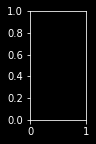

In [376]:
sp500.visualize()

In [377]:
stock.TickerCharts()

'https://finviz.com/chart.ashx?t=tsla&ty=c&ta=1&p=d'

In [154]:
fv('AAPL').TickerFundament()

{'Company': 'Apple Inc.',
 'Sector': 'Technology',
 'Industry': 'Consumer Electronics',
 'Country': 'USA',
 'Index': 'DJIA S&P500',
 'P/E': '29.87',
 'EPS (ttm)': '5.11',
 'Insider Own': '0.07%',
 'Shs Outstand': '16.63B',
 'Perf Week': '2.80%',
 'Market Cap': '2503.03B',
 'Forward P/E': '26.92',
 'EPS next Y': '1.49%',
 'Insider Trans': '-18.86%',
 'Shs Float': '16.36B',
 'Perf Month': '3.49%',
 'Income': '86.80B',
 'PEG': '1.52',
 'EPS next Q': '1.23',
 'Inst Own': '58.60%',
 'Short Float': '0.57%',
 'Perf Quarter': '23.45%',
 'Sales': '347.15B',
 'P/S': '7.21',
 'EPS this Y': '10.20%',
 'Inst Trans': '-0.99%',
 'Short Ratio': '1.21',
 'Perf Half Y': '26.95%',
 'Book/sh': '3.87',
 'P/B': '39.41',
 'ROA': '25.80%',
 'Target Price': '166.37',
 'Perf Year': '13.66%',
 'Cash/sh': '3.76',
 'P/C': '40.57',
 'EPS next 5Y': '19.61%',
 'ROE': '131.00%',
 '52W Range From': '103.10',
 '52W Range To': '153.49',
 'Perf YTD': '14.94%',
 'Dividend': '0.88',
 'P/FCF': '31.12',
 'EPS past 5Y': '7.30%